In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from typing import Tuple
from utils import build_midprice_from_df_OB, to_regular_time_series
import warnings  
warnings.filterwarnings('ignore')

# Explore Datas and plot them

In [3]:
df_message = pd.read_csv("HF_Data/LOBSTER_SampleFile_MSFT_2012-06-21_50/MSFT_2012-06-21_34200000_37800000_message_50.csv")
df_message.head()

,34200.01399412,3,16085616,100,310400,-1
0,34200.013994,1,16116348,100,310500,-1
1,34200.015248,1,16116658,100,310400,-1
2,34200.015442,1,16116704,100,310500,-1
3,34200.015789,1,16116752,100,310600,-1
4,34200.016300,1,16116815,100,310700,-1


In [4]:
# Renommer les colonnes de df_messages selon la spécification
rename_mapping = {
    df_message.columns[0]: "Time",        # Seconds after midnight (float, ms à ns)
    df_message.columns[1]: "Type",        # Type d'événement (1,2,3,4,5,7)
    df_message.columns[2]: "OrderID",     # Identifiant unique de l'ordre
    df_message.columns[3]: "Size",        # Nombre d'actions
    df_message.columns[4]: "Price",       # Prix * 10 000
    df_message.columns[5]: "Direction"    # -1: Sell, 1: Buy
}

df_message = df_message.rename(columns=rename_mapping)

# Vérification
print(df_message.head())
print("\nColonnes renommées :", df_message.columns.tolist())


           Time  Type   OrderID  Size   Price  Direction
0  34200.013994     1  16116348   100  310500         -1
1  34200.015248     1  16116658   100  310400         -1
2  34200.015442     1  16116704   100  310500         -1
3  34200.015789     1  16116752   100  310600         -1
4  34200.016300     1  16116815   100  310700         -1

Colonnes renommées : ['Time', 'Type', 'OrderID', 'Size', 'Price', 'Direction']


In [5]:
df_OB  = pd.read_csv("HF_Data/LOBSTER_SampleFile_MSFT_2012-06-21_50/MSFT_2012-06-21_34200000_37800000_orderbook_50.csv")
df_OB.head()

,309900,3788,309500,300,310500,100,309300,3986,310600,100.1,...,-9999999999.7,0.20,9999999999.13,0.21,-9999999999.8,0.22,9999999999.14,0.23,-9999999999.9,0.24
0,309900,3788,309500,300,310500,200,309300,3986,310600,100,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
1,309900,3788,309500,300,310400,100,309300,3986,310500,200,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
2,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0


In [6]:
num_levels = 50

new_columns = []
for level in range(1, num_levels + 1):
    new_columns += [
        f"AskPrice_{level}",  # Prix Ask du niveau i
        f"AskSize_{level}",   # Volume Ask du niveau i
        f"BidPrice_{level}",  # Prix Bid du niveau i
        f"BidSize_{level}",   # Volume Bid du niveau i
    ]

if len(df_OB.columns) != len(new_columns):
    raise ValueError(
        f"Le DataFrame df_OB contient {len(df_OB.columns)} colonnes, "
        f"mais {len(new_columns)} étaient attendues pour {num_levels} niveaux."
    )

df_OB.columns = new_columns

print(df_OB.columns[:8])  # affiche les premières colonnes pour vérif
print(f"\nTotal colonnes renommées : {len(df_OB.columns)}")


Index(['AskPrice_1', 'AskSize_1', 'BidPrice_1', 'BidSize_1', 'AskPrice_2',
       'AskSize_2', 'BidPrice_2', 'BidSize_2'],
      dtype='object')

Total colonnes renommées : 200


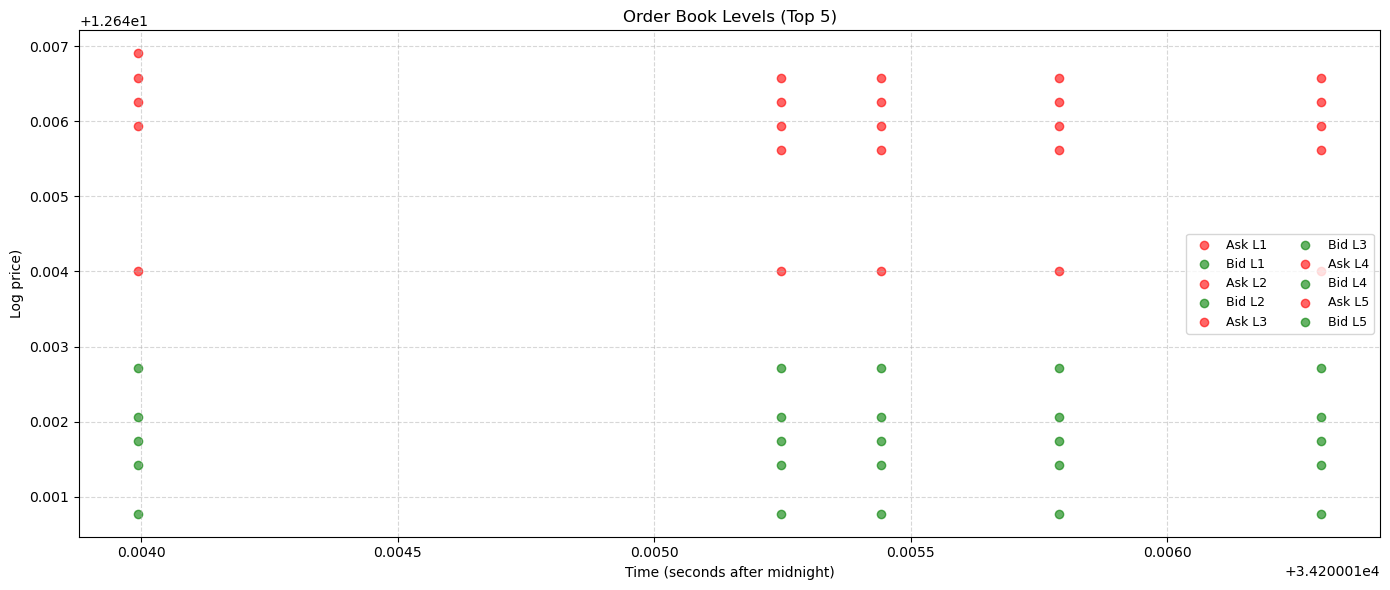

In [7]:
df_OB_with_time = df_OB.copy()
df_OB_with_time["Time"] = df_message["Time"].values

num_levels_to_plot = 5

plt.figure(figsize=(14, 6))

for i in range(1, num_levels_to_plot + 1):
    plt.scatter(df_OB_with_time["Time"][:5], np.log(df_OB_with_time[f"AskPrice_{i}"][:5]), 
             label=f"Ask L{i}", color="red", alpha=0.6)
    plt.scatter(df_OB_with_time["Time"][:5], np.log(df_OB_with_time[f"BidPrice_{i}"][:5]), 
             label=f"Bid L{i}", color="green", alpha=0.6)

plt.xlabel("Time (seconds after midnight)")
plt.ylabel("Log price)")
plt.title(f"Order Book Levels (Top {num_levels_to_plot})")
plt.legend(ncol=2, fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Simulation of Stochastic Volatility process

## Euler Maryama type

In [8]:
# ===========================
# PARAMÈTRES GLOBAUX
# ===========================
T = 1.0        # horizon temporel
N = 1000       # nombre de pas
dt = T / N
t = np.linspace(0, T, N+1)

beta_0 = -0.5  # constante du log-vol
mu = 1.2       # drift de X_t

In [9]:
# ===========================
# SIMULATION
# ===========================
def simulate_process(rho=0.5, alpha=-2.0, beta_1=0.8, seed=42):
    np.random.seed(seed)
    X = np.zeros(N+1)
    tau = np.zeros(N+1)
    
    for i in range(N):
        # Génération des normales corrélées
        Z1, Z2 = np.random.normal(0, 1, 2)
        Z2_corr = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        dB = np.sqrt(dt) * Z1
        dW = np.sqrt(dt) * Z2_corr
        
        sigma_t = np.exp(beta_0 + beta_1 * tau[i])
        
        # Mise à jour Euler–Maruyama
        X[i+1] = X[i] + mu * dt + sigma_t * dB
        tau[i+1] = tau[i] + alpha * tau[i] * dt + dW
    
    sigma = np.exp(beta_0 + beta_1 * tau)
    return t, X, tau, sigma

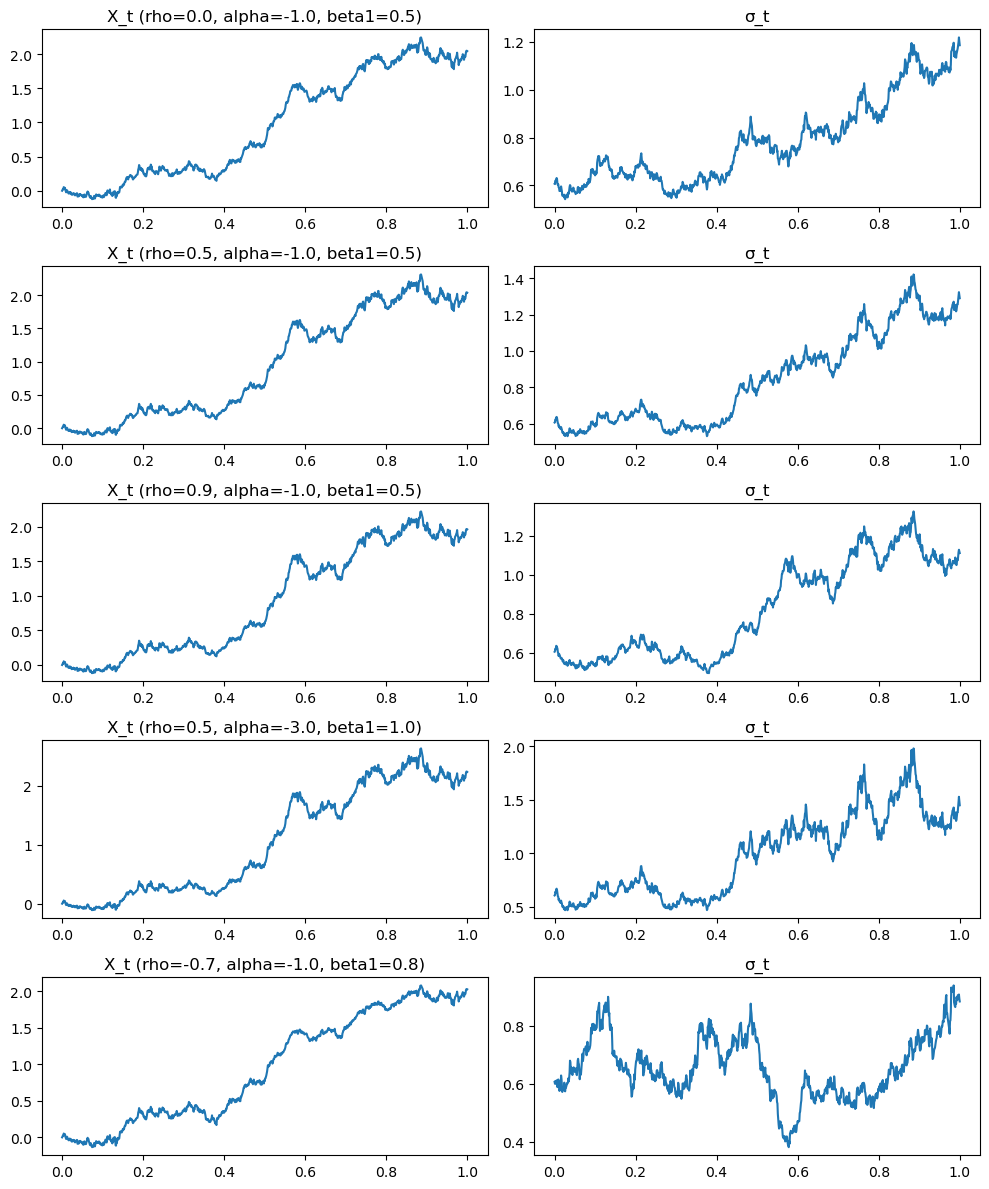

In [10]:
# ===========================
# VISUALISATION
# ===========================
params = [
    {"rho": 0.0, "alpha": -1.0, "beta_1": 0.5},
    {"rho": 0.5, "alpha": -1.0, "beta_1": 0.5},
    {"rho": 0.9, "alpha": -1.0, "beta_1": 0.5},
    {"rho": 0.5, "alpha": -3.0, "beta_1": 1.0},
    {"rho": -0.7, "alpha": -1.0, "beta_1": 0.8},
]

fig, axes = plt.subplots(len(params), 2, figsize=(10, 12))
for i, p in enumerate(params):
    t, X, tau, sigma = simulate_process(**p)
    axes[i, 0].plot(t, X)
    axes[i, 0].set_title(f"X_t (rho={p['rho']}, alpha={p['alpha']}, beta1={p['beta_1']})")
    axes[i, 1].plot(t, sigma)
    axes[i, 1].set_title("σ_t")
plt.tight_layout()
plt.show()

## GARCH-SV Model

In [12]:
# ==================================================
# PARAMETERS
# ==================================================
T = 1.0
N = 2000
dt = T / N
t = np.linspace(0, T, N + 1)

# Base parameters
omega0 = 0.05
alpha0_values = [0.05, 0.2, 0.5]
beta0_values = [0.5, 2.0, 5.0]

In [13]:
def simulate_garch_sv(omega0, alpha0, beta0, seed=42):
    np.random.seed(seed)
    
    X = np.zeros(N + 1)
    sigma2 = np.zeros(N + 1)
    sigma2[0] = omega0 / beta0  # start at long-term mean variance
    
    for i in range(N):
        Z1, Z2 = np.random.normal(0, 1, 2)
        
        # Ensure positivity of variance
        sigma = np.sqrt(max(sigma2[i], 1e-8))
        
        # SDE updates (Euler-Maruyama)
        X[i + 1] = X[i] + sigma * np.sqrt(dt) * Z1
        sigma2[i + 1] = sigma2[i] + (omega0 - beta0 * sigma2[i]) * dt + np.sqrt(2 * alpha0) * sigma * np.sqrt(dt) * Z2
        
        # Keep non-negative variance
        sigma2[i + 1] = max(sigma2[i + 1], 0)
    
    return t, X, sigma2


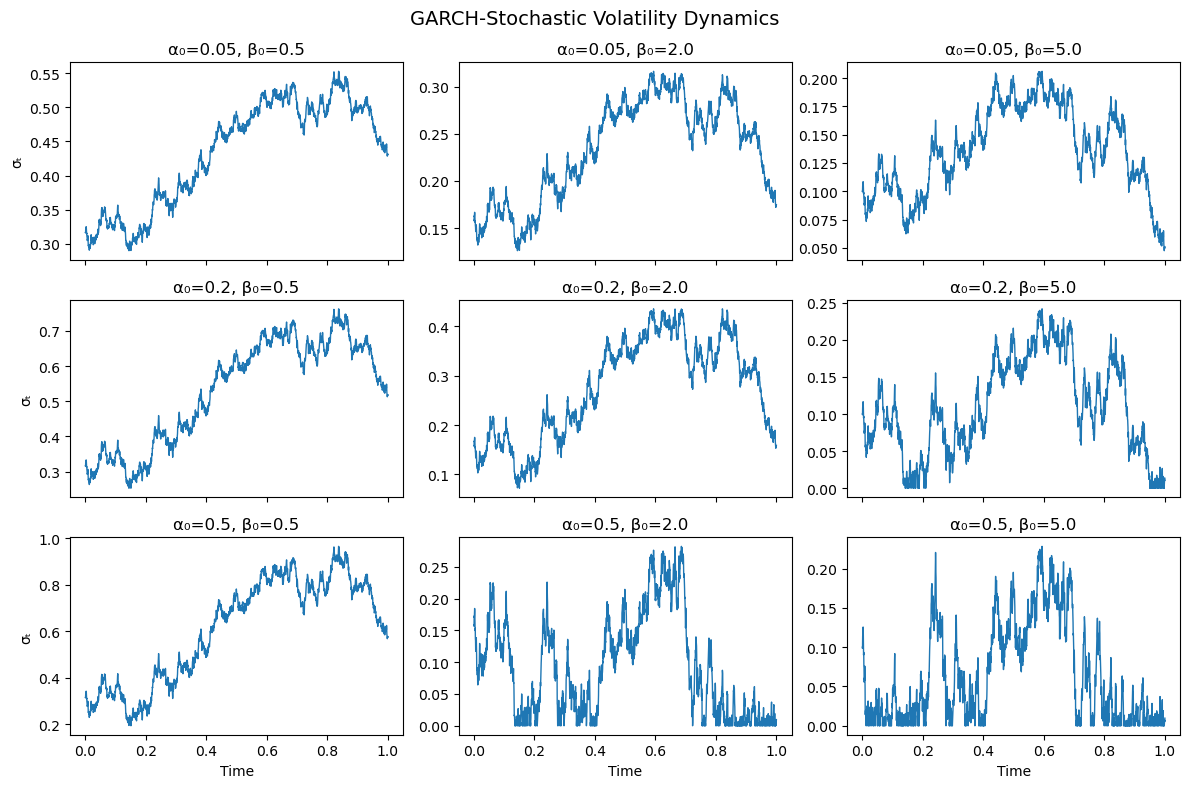

In [14]:
# ==================================================
# PLOTS
# ==================================================
fig, axes = plt.subplots(len(alpha0_values), len(beta0_values), figsize=(12, 8), sharex=True, sharey=False)
for i, alpha0 in enumerate(alpha0_values):
    for j, beta0 in enumerate(beta0_values):
        t, X, sigma2 = simulate_garch_sv(omega0, alpha0, beta0)
        axes[i, j].plot(t, np.sqrt(sigma2), color="tab:blue", lw=1)
        axes[i, j].set_title(f"α₀={alpha0}, β₀={beta0}")
        if i == len(alpha0_values) - 1:
            axes[i, j].set_xlabel("Time")
        if j == 0:
            axes[i, j].set_ylabel("σₜ")
plt.suptitle("GARCH-Stochastic Volatility Dynamics", fontsize=14)
plt.tight_layout()
plt.show()

# Volatility Estimation by 3 different methods

In [ ]:
# -----------------------
# Realized Volatility with subsampling 
# -----------------------
def realized_vol_subsampling(prices: pd.Series,
                             window_start_time: pd.Timestamp,
                             window_end_time: pd.Timestamp,
                             dt_seconds: float = 1.0,
                             m_sub: int = 5) -> float:
    """
    Compute realized variance on [window_start_time, window_end_time] using subsampling.
    prices: pd.Series indexed by pd.DatetimeIndex on a regular grid (e.g. 1s)
    dt_seconds: grid spacing in seconds
    m_sub: number of subsamples (shifts)
    Returns realized variance (sum of squared returns).
    """
    # subset the window
    sub = prices.loc[window_start_time:window_end_time]
    if len(sub) < 2:
        return np.nan

    n = len(sub)
    # convert to numpy array
    x = sub.values
    # For simplicity: create m shifted series by skipping first s samples for s in [0,m-1]
    subs_rv = []
    for s in range(m_sub):
        # take indices s, s+k, s+2k,... where k = m_sub
        idx = np.arange(s, n, m_sub)
        if idx.size < 2:
            continue
        xs = x[idx]
        r = np.diff(np.log(xs))  # log returns
        subs_rv.append(np.sum(r**2))
    if len(subs_rv) == 0:
        return np.nan
    return float(np.mean(subs_rv))

In [ ]:
# -----------------------
# Pre-averaging estimator
# -----------------------
def preaveraging_rv(prices: pd.Series,
                    window_start_time: pd.Timestamp,
                    window_end_time: pd.Timestamp,
                    k: int = None) -> float:
    """
    Pre-averaging realized variance estimator on a regular grid of returns.
    prices: pd.Series indexed by DatetimeIndex
    k: block size for pre-averaging (if None choose floor(n**0.5))
    Returns estimated integrated variance on the window.
    Implementation follows the discrete pre-averaging idea with weight g(u)=u ∧ (1-u).
    Note: constant factors chosen for practical estimation — may need theoretical scaling for asymptotics.
    """
    sub = prices.loc[window_start_time:window_end_time]
    if len(sub) < 5:
        return np.nan
    logp = np.log(sub.values)
    n = len(logp) - 1  # number of returns
    r = np.diff(logp)  # returns r_1...r_n

    if k is None:
        k = int(np.floor(np.sqrt(n)))
    if k < 2:
        k = 2

    # weight g
    j = np.arange(1, k+1)
    g = np.minimum(j / k, 1 - j / k)
    # pre-averaged returns (length n-k+1)
    pa = []
    for i in range(0, n - k + 1):
        window_r = r[i:i + k]
        # note: multiplication length must match: use g[0:k]
        pa.append(np.dot(g, window_r))
    pa = np.array(pa)

    # constant psi = sum g^2
    psi = np.sum(g**2)
    # estimator (practical scaling)
    # see e.g. Jacod, Li 2009: IV_hat = (1 / (psi * k)) * sum(pa^2)
    iv_hat = (1.0 / (psi * k)) * np.sum(pa**2)
    return float(iv_hat)

In [ ]:
# -----------------------
# Realized Kernel estimator 
# -----------------------
def realized_kernel(prices: pd.Series,
                    window_start_time: pd.Timestamp,
                    window_end_time: pd.Timestamp,
                    H: int = None) -> float:
    """
    Realized kernel estimator using Bartlett kernel.
    returns gamma_h autocovariances weighted by kernel.
    H: bandwidth (lag truncation). If None choose floor(n**(1/3))
    """
    sub = prices.loc[window_start_time:window_end_time]
    if len(sub) < 3:
        return np.nan
    logp = np.log(sub.values)
    r = np.diff(logp)
    n = len(r)
    if H is None:
        H = int(np.floor(n ** (1.0 / 3.0)))
    if H < 1:
        H = 1

    # sample autocovariances gamma_h for h=0..H
    gamma = np.zeros(H + 1)
    for h in range(0, H + 1):
        if h == 0:
            gamma[h] = np.sum(r * r)
        else:
            gamma[h] = np.sum(r[h:] * r[:-h])

    # Bartlett kernel: k(x) = 1 - |x| for |x|<=1
    weights = np.array([1.0 if h == 0 else (1.0 - h/(H+1)) for h in range(0, H + 1)])  # alternative scaling
    # Another common Bartlett: weight_h = 1 - h/H  (we use H+1 to avoid zero at h=H)
    # compute estimator: gamma_0 + 2 * sum_{h=1}^H weight_h * gamma_h
    rv = gamma[0] + 2.0 * np.sum(weights[1:] * gamma[1:])
    return float(rv)

In [ ]:
# -----------------------
# compute estimators on rolling windows
# -----------------------
def compute_intraday_estimators(reg_prices: pd.Series,
                                window_seconds: int = 300,
                                step_seconds: int = 60,
                                subs_m: int = 5,
                                pre_k: int = None,
                                kernel_H: int = None) -> pd.DataFrame:
    """
    reg_prices: pd.Series indexed by DatetimeIndex (regular grid).
    Returns DataFrame with columns ['window_end','RV_sub','RV_preavg','RV_kernel'] evaluated on windows of length window_seconds,
    moving by step_seconds.
    """
    idx = reg_prices.index
    start = idx[0]
    end = idx[-1]
    windows = []
    cur = start + pd.Timedelta(seconds=window_seconds)
    while cur <= end:
        ws = cur - pd.Timedelta(seconds=window_seconds)
        we = cur
        rv_sub = realized_vol_subsampling(reg_prices, ws, we, dt_seconds= (reg_prices.index[1]-reg_prices.index[0]).total_seconds(), m_sub=subs_m)
        rv_pre = preaveraging_rv(reg_prices, ws, we, k=pre_k)
        rv_ker = realized_kernel(reg_prices, ws, we, H=kernel_H)
        windows.append({'window_end': we, 'RV_sub': rv_sub, 'RV_preavg': rv_pre, 'RV_kernel': rv_ker})
        cur += pd.Timedelta(seconds=step_seconds)
    out = pd.DataFrame(windows).set_index('window_end')
    return out

In [ ]:
def plot_estimators(est_df: pd.DataFrame, title: str = "Intraday Vol Estimators (windowed)"):
    plt.figure(figsize=(12,5))
    # convert to volatility (sqrt) and annualize if needed
    plt.plot(np.sqrt(est_df['RV_sub']), label='Subsampling RV (sqrt)')
    plt.plot(np.sqrt(est_df['RV_preavg']), label='Pre-averaging RV (sqrt)')
    plt.plot(np.sqrt(est_df['RV_kernel']), label='Realized Kernel (sqrt)')
    plt.legend()
    plt.title(title)
    plt.xlabel('window end time')
    plt.ylabel('volatility (sqrt of estimated variance)')
    plt.grid(True)
    plt.show()

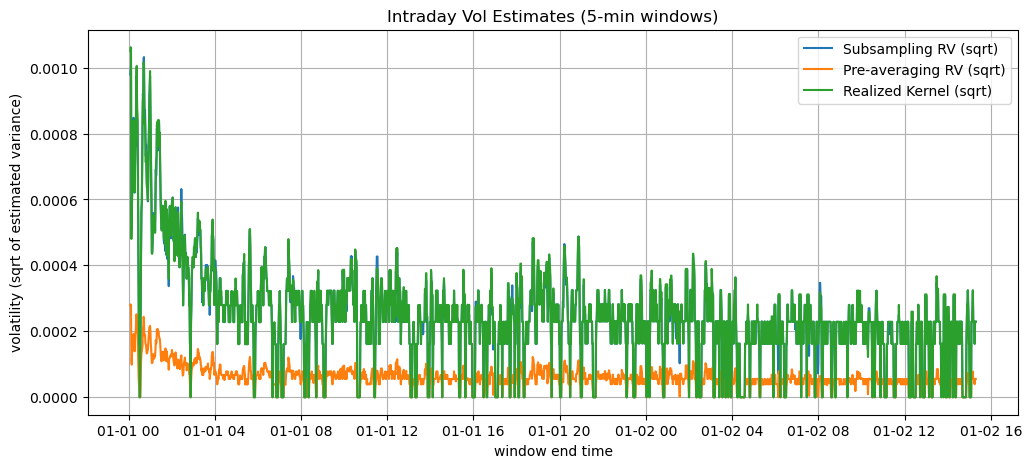

                           RV_sub     RV_preavg     RV_kernel
window_end                                                   
2020-01-01 00:05:00  9.586418e-07  7.785504e-08  1.101589e-06
2020-01-01 00:06:00  9.846773e-07  7.936777e-08  1.127625e-06
2020-01-01 00:07:00  1.010590e-06  7.552298e-08  1.123775e-06
2020-01-01 00:08:00  2.603674e-07  1.238650e-08  2.306043e-07
2020-01-01 00:09:00  3.436711e-07  9.755711e-09  3.347297e-07


In [ ]:
if __name__ == "__main__":
    # 1) Build midprice
    # df_OB must be in the namespace
    try:
        mid_df = build_midprice_from_df_OB(df_OB, ask_col='AskPrice_1', bid_col='BidPrice_1', price_scale=10000.0)
    except NameError:
        raise RuntimeError("df_OB not found in namespace. Please provide df_OB as described.")

    # 2) Regularize / resample to 1-second grid (adjust dt_seconds to your tick frequency)
    reg = to_regular_time_series(mid_df, dt_seconds=1.0)  # 1-second grid; adjust if needed
    prices = reg['price']

    # 3) Compute estimators on rolling 5-minute windows, step 1 minute
    est = compute_intraday_estimators(prices,
                                      window_seconds=300,   # 5 minutes
                                      step_seconds=60,      # 1 minute
                                      subs_m=5,             # subsampling shifts
                                      pre_k=None,           # default sqrt(n) inside function
                                      kernel_H=None)        # default n^(1/3)
    # 4) Plot
    plot_estimators(est, title='Intraday Vol Estimates (5-min windows)')

    print(est.head())

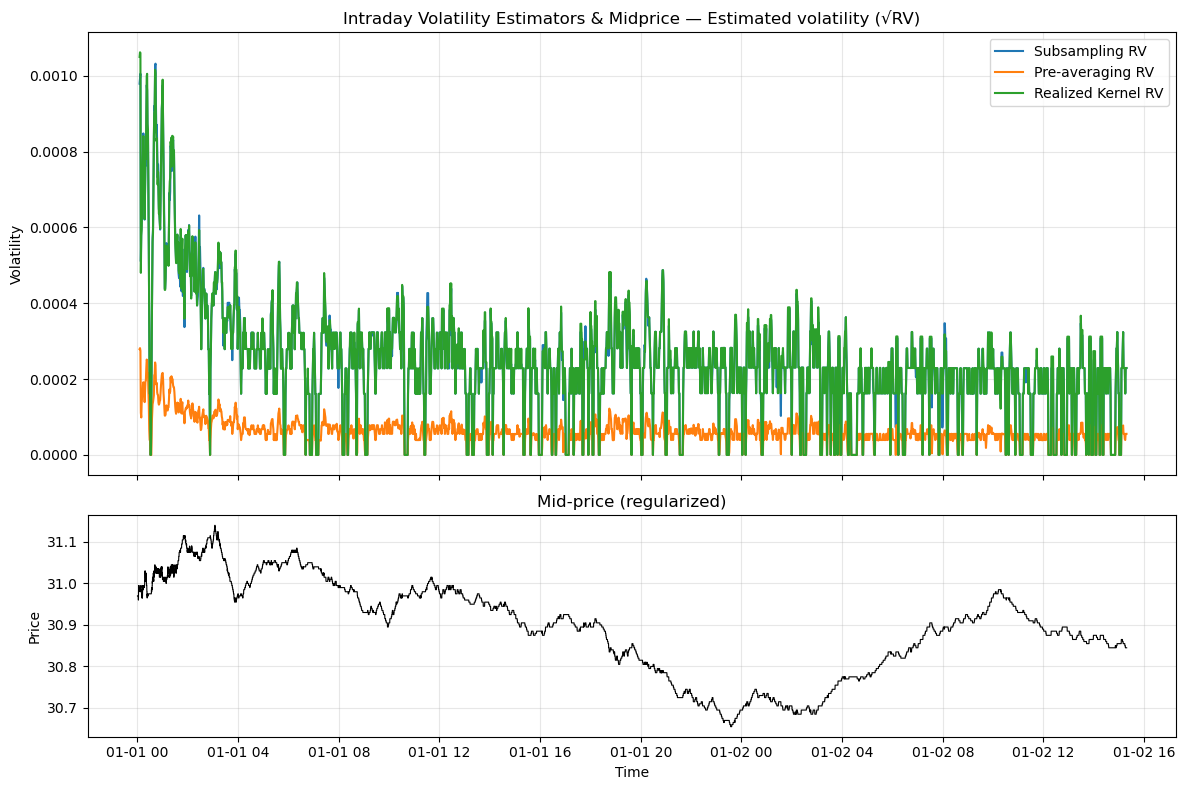

In [24]:
def plot_estimators_with_price(est_df: pd.DataFrame, prices: pd.Series, title: str = "Intraday Vol & Price"):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    # --- Plot vol estimators (upper panel)
    axes[0].plot(np.sqrt(est_df['RV_sub']), label='Subsampling RV', color='tab:blue')
    axes[0].plot(np.sqrt(est_df['RV_preavg']), label='Pre-averaging RV', color='tab:orange')
    axes[0].plot(np.sqrt(est_df['RV_kernel']), label='Realized Kernel RV', color='tab:green')
    axes[0].legend()
    axes[0].set_title(title + " — Estimated volatility (√RV)")
    axes[0].set_ylabel("Volatility")
    axes[0].grid(True, alpha=0.3)

    # --- Plot mid-price (lower panel)
    axes[1].plot(prices, color='black', linewidth=0.8)
    axes[1].set_title("Mid-price (regularized)")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Price")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_estimators_with_price(est, prices, title='Intraday Volatility Estimators & Midprice')


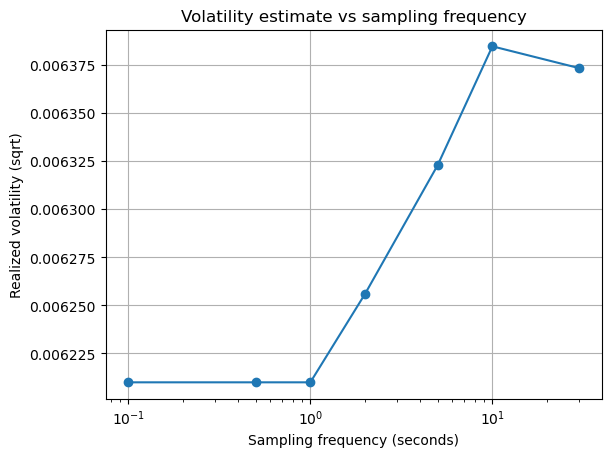

In [ ]:
def volatility_by_frequency(prices, freqs_seconds=[0.5, 1, 2, 5, 10, 30, 60]):
    res = []
    for dt in freqs_seconds:
        reg = to_regular_time_series(pd.DataFrame({'Time': np.arange(len(prices)), 'midprice': prices}), dt_seconds=dt)
        series = reg['price']
        rv = np.sum(np.diff(np.log(series))**2)
        res.append({'freq': dt, 'RV': rv})
    df = pd.DataFrame(res)
    df['Vol'] = np.sqrt(df['RV'])
    return df

df_freq = volatility_by_frequency(mid_df['midprice'], freqs_seconds=[0.1, 0.5, 1, 2, 5, 10, 30])
plt.plot(df_freq['freq'], df_freq['Vol'], marker='o')
plt.xscale('log')
plt.xlabel("Sampling frequency (seconds)")
plt.ylabel("Realized volatility (sqrt)")
plt.title("Volatility estimate vs sampling frequency")
plt.grid(True)
plt.show()

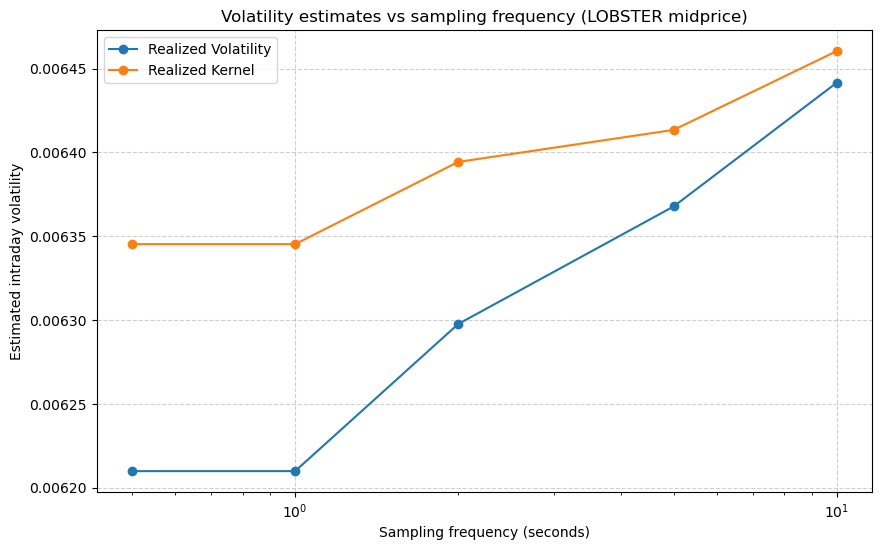

   freq        RV    PreAvg    Kernel
0   0.5  0.006210  0.138565  0.006345
1   1.0  0.006210  0.138565  0.006345
2   2.0  0.006298  0.120754  0.006394
3   5.0  0.006368  0.100001  0.006413
4  10.0  0.006442  0.086831  0.006460


In [ ]:
def realized_volatility(log_returns):
    """Realized Volatility (classique)."""
    return np.sqrt(np.sum(log_returns**2))

def pre_averaging_volatility(log_returns, k=None):
    """
    Pre-averaging realized variance estimator with correct scaling.
    log_returns: array of log-returns on regular grid
    k: block size for pre-averaging (default sqrt(n))
    """
    n = len(log_returns)
    if n < 5:
        return np.nan
    
    if k is None:
        k = int(np.floor(np.sqrt(n)))
    if k < 2:
        k = 2
    
    # g weights: g(j/k) = min(j/k,1-j/k)
    j = np.arange(1, k+1)
    g = np.minimum(j/k, 1 - j/k)
    
    # pre-averaged returns
    pa = np.array([np.dot(g, log_returns[i:i+k]) for i in range(n-k+1)])
    
    # sum g^2
    psi2 = np.sum(g**2)
    
    # scale by n / (k * psi2)
    iv_hat = (n / ((k * psi2))) * np.sum(pa**2)
    
    return np.sqrt(iv_hat)


def realized_kernel_volatility(log_returns, bandwidth=5):
    """Realized kernel volatility (simplified version with Bartlett kernel)."""
    n = len(log_returns)
    gamma0 = np.sum(log_returns**2)
    kernel = 0
    for lag in range(1, bandwidth):
        weight = 1 - lag / (bandwidth + 1)
        gamma = np.sum(log_returns[lag:] * log_returns[:-lag])
        kernel += 2 * weight * gamma
    return np.sqrt(gamma0 + kernel)

def regularize_midprice(df, dt_seconds):
    """Resample midprice to a regular grid."""
    df = df.copy()
    df['Time'] = pd.to_timedelta(df['Time'], unit='s')
    df = df.set_index('Time').resample(f'{dt_seconds}S').last().dropna()
    df['log_price'] = np.log(df['midprice'])
    df['log_ret'] = df['log_price'].diff().dropna()
    return df.dropna()

# Params
freqs = [0.5, 1, 2, 5, 10]  # secondes
results = []

for dt in freqs:
    df_resampled = regularize_midprice(mid_df, dt)
    r = df_resampled['log_ret'].values
    
    rv = realized_volatility(r)
    pa = pre_averaging_volatility(r)
    rk = realized_kernel_volatility(r)
    
    results.append({'freq': dt, 'RV': rv, 'PreAvg': pa, 'Kernel': rk})

df_res = pd.DataFrame(results)

#Plot
plt.figure(figsize=(10,6))
plt.plot(df_res['freq'], df_res['RV'], marker='o', label='Realized Volatility')
# plt.plot(df_res['freq'], df_res['PreAvg'], marker='o', label='Pre-Averaging') # Un peu trop loin des valeurs des 2 autres
plt.plot(df_res['freq'], df_res['Kernel'], marker='o', label='Realized Kernel')

plt.xscale('log')
plt.xlabel('Sampling frequency (seconds)')
plt.ylabel('Estimated intraday volatility')
plt.title('Volatility estimates vs sampling frequency (LOBSTER midprice)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


print(df_res)